In [2]:
!pip install pyspark==3.1.2 spark-nlp==3.4.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212.4 MB 68 kB/s 
     |████████████████████████████████| 142 kB 25.8 MB/s 
     |████████████████████████████████| 198 kB 79.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880769 sha256=71c2f3e8a76a08a86abb1ae0775e0b85891f7bd66f9af59b8086e969776abd68
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [3]:
import sparknlp
from sparknlp.base import *
from sparknlp.common import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from pyspark.sql.types import *

In [4]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [5]:
import os
import sys
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
import re
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.types import DateType
import pyspark.sql.functions as F

sns.set(style="whitegrid")

In [6]:
## Start Spark Session
spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

Spark NLP version 3.4.2
Apache Spark version: 3.1.2


In [7]:
# Create SparkSession
#spark = SparkSession.builder.master("local").appName("DSCI_632_Final").getOrCreate() 

In [8]:
business_dataset = spark.read.json('./drive/MyDrive/Cloud-Computing-Project/yelp_academic_dataset_business.json')

In [9]:
business_dataset.show()

+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|          city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{null, null, null...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...| Santa Barbara|                null|      0|   34.4266787|  -119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{null, null, null...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|        Affton|{8:0-18:30, 0:0-0...|      1|   

In [10]:
business_dataset.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [11]:
print('Total number of business:', business_dataset.count())

Total number of business: 150346


In [12]:
# drop null values
business_dataset = business_dataset.dropna('any')
print('Total number of business after dropping the null vlaues:', business_dataset.count())

Total number of business after dropping the null vlaues: 117618


In [13]:
# rename name to busines Name's
business_dataset = business_dataset.withColumnRenamed('name','busines_Name')

In [14]:
# rename stars to rating
business_dataset = business_dataset.withColumnRenamed('stars','rating')

In [15]:
business_dataset.columns

['address',
 'attributes',
 'business_id',
 'categories',
 'city',
 'hours',
 'is_open',
 'latitude',
 'longitude',
 'busines_Name',
 'postal_code',
 'review_count',
 'rating',
 'state']

In [16]:
# drop unneeded columns 
business_dataset = business_dataset.drop('address','attributes','latitude','longitude','postal_code','hours','is_open')

In [17]:
business_dataset =business_dataset.filter(col("state")=='PA')

In [18]:
business_dataset.show(3,truncate=False)

+----------------------+-----------------------------------------------------+------------+------------------------+------------+------+-----+
|business_id           |categories                                           |city        |busines_Name            |review_count|rating|state|
+----------------------+-----------------------------------------------------+------------+------------------------+------------+------+-----+
|MTSW4McQd7CbVtyjqoe9mw|Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries|Philadelphia|St Honore Pastries      |80          |4.0   |PA   |
|mWMc6_wTdE0EUBKIGXDVfA|Brewpubs, Breweries, Food                            |Green Lane  |Perkiomen Valley Brewery|13          |4.5   |PA   |
|MUTTqe8uqyMdBl186RmNeA|Sushi Bars, Restaurants, Japanese                    |Philadelphia|Tuna Bar                |245         |4.0   |PA   |
+----------------------+-----------------------------------------------------+------------+------------------------+------------+------+-----+

In [19]:
business_dataset.count()

26317

In [20]:
business_dataset.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- city: string (nullable = true)
 |-- busines_Name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- state: string (nullable = true)



In [21]:
business_dataset = business_dataset.filter( (business_dataset.rating  == 1.0) | (business_dataset.rating  == 2.0) |(business_dataset.rating  == 3.0) | (business_dataset.rating  == 4.0) | (business_dataset.rating  == 5.0) )

In [22]:
# count rating in the dataset from 1(bad) to 5(good) 
business_dataset.groupBy('rating').count().sort('rating',ascending=False).show(truncate=False)

+------+-----+
|rating|count|
+------+-----+
|5.0   |2710 |
|4.0   |5724 |
|3.0   |3326 |
|2.0   |1531 |
|1.0   |173  |
+------+-----+



In [23]:
# top categories 
each_category = business_dataset.select('categories').select(explode(split('categories', ', ')).alias('category'))
grouped_category = each_category.groupby('category').count()
top_category = grouped_category.sort('count',ascending=False)
top_category.show(truncate=False)

+-------------------------+-----+
|category                 |count|
+-------------------------+-----+
|Restaurants              |5252 |
|Food                     |2752 |
|Shopping                 |2320 |
|Beauty & Spas            |1463 |
|Home Services            |1292 |
|Health & Medical         |1159 |
|Nightlife                |1139 |
|Local Services           |1136 |
|Bars                     |1046 |
|Sandwiches               |969  |
|Event Planning & Services|885  |
|Pizza                    |867  |
|Automotive               |862  |
|American (Traditional)   |832  |
|Coffee & Tea             |775  |
|American (New)           |704  |
|Breakfast & Brunch       |663  |
|Active Life              |636  |
|Italian                  |634  |
|Hair Salons              |599  |
+-------------------------+-----+
only showing top 20 rows



In [24]:
# most top review with 3 rating or more
top_rating = business_dataset.filter('rating >= 3').groupby('busines_Name').count()
review_sort = top_rating.sort('count',ascending=False).show(truncate=False)

+---------------------------------------------+-----+
|busines_Name                                 |count|
+---------------------------------------------+-----+
|Wawa                                         |65   |
|Starbucks                                    |53   |
|Dunkin'                                      |37   |
|Hair Cuttery                                 |21   |
|CVS Pharmacy                                 |20   |
|PrimoHoagies                                 |17   |
|Rita's Italian Ice                           |17   |
|Chick-fil-A                                  |15   |
|The UPS Store                                |15   |
|Target                                       |15   |
|Planet Fitness                               |15   |
|Supercuts                                    |14   |
|Saladworks                                   |13   |
|ACME Markets                                 |12   |
|US Post Office                               |12   |
|Hand & Stone Massage and Fa

In [25]:
lowest_rating = business_dataset.filter('rating < 3').groupby('busines_Name').count()
review_sort = lowest_rating.sort('count',ascending=False )
review_sort.show(truncate=False)

+-------------------------+-----+
|busines_Name             |count|
+-------------------------+-----+
|Dunkin'                  |69   |
|McDonald's               |51   |
|CVS Pharmacy             |30   |
|Wendy's                  |26   |
|Domino's Pizza           |20   |
|US Post Office           |19   |
|Burger King              |19   |
|Rite Aid                 |15   |
|Popeyes Louisiana Kitchen|15   |
|Pizza Hut                |15   |
|Chipotle Mexican Grill   |15   |
|Starbucks                |15   |
|KFC                      |14   |
|AT&T Store               |13   |
|Papa John's Pizza        |12   |
|Taco Bell                |12   |
|ACME Markets             |12   |
|Pep Boys                 |11   |
|Wawa                     |10   |
|Walgreens                |9    |
+-------------------------+-----+
only showing top 20 rows



In [26]:
business_dataset.write.saveAsTable("businessIPA")

In [27]:
query = "SELECT * FROM businessIPA WHERE categories LIKE '%Restaurants%'";
Restaurants = spark.sql(query)

In [28]:
Restaurants = Restaurants.filter( (Restaurants.rating  == 1.0) | (Restaurants.rating  == 2.0) |(Restaurants.rating  == 3.0) | (Restaurants.rating  == 4.0) | (Restaurants.rating  == 5.0) )

In [29]:
Restaurants.show()

+--------------------+--------------------+---------------+--------------------+------------+------+-----+
|         business_id|          categories|           city|        busines_Name|review_count|rating|state|
+--------------------+--------------------+---------------+--------------------+------------+------+-----+
|5oiYQkCMlJ2nZEjtt...|American (Traditi...|   Philadelphia|    Fourth and Cross|          49|   4.0|   PA|
|iakga716_hy0m7svR...|Mexican, Restaura...|   Philadelphia|        Paisas Pizza|          10|   3.0|   PA|
|mohbgbizdjgDiXerm...|Chinese, Restaurants|   Philadelphia|         No. 1 China|          40|   3.0|   PA|
|UGMIzqfga5uLqMct6...|Tacos, Tex-Mex, F...|       Richboro|           Taco Bell|          18|   3.0|   PA|
|ZXXCgGKY1z1An65yv...|Restaurants, Burgers|   Philadelphia|          Burger.Org|          55|   3.0|   PA|
|OKmwUmfWO3e3Zpfzh...|Pizza, Restaurant...|   Philadelphia|      Urban Shop 543|          15|   4.0|   PA|
|KjdGQMxhgW25Fn_A-...|Restaurants, Ch

In [30]:
#Restaurants.write.saveAsTable("Restaurants")

In [31]:
Restaurants.count()

5252

In [32]:
Restaurants.groupBy('rating').count().sort(desc("rating")).show(10,truncate=False) 

+------+-----+
|rating|count|
+------+-----+
|5.0   |266  |
|4.0   |2875 |
|3.0   |1590 |
|2.0   |482  |
|1.0   |39   |
+------+-----+



In [33]:
Restaurants_df = Restaurants.toPandas()

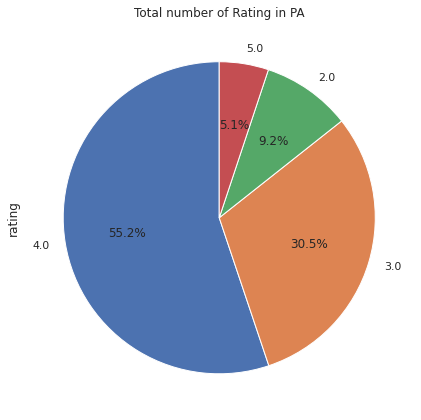

In [34]:
plt.figure(figsize=(8,6))
Restaurants_df['rating'].value_counts()[:5].plot.pie(autopct='%1.1f%%', startangle=90)
plt.tight_layout()

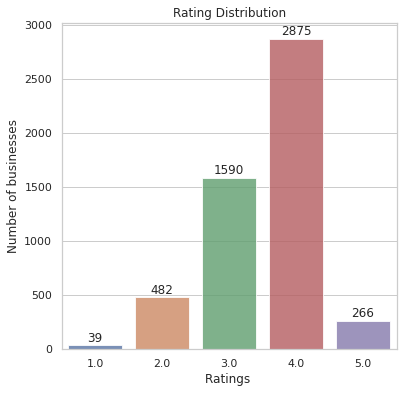

In [35]:
x=Restaurants_df['rating'].value_counts()
x=x.sort_index()
#plot
plt.figure(figsize=(6,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Rating Distribution")
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('Ratings ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [36]:
city =Restaurants.groupBy('city').count().groupBy('city').sum()
city.sort('sum(count)',ascending= False).show(truncate=False) 

+---------------+----------+
|city           |sum(count)|
+---------------+----------+
|Philadelphia   |2400      |
|West Chester   |123       |
|Doylestown     |69        |
|Norristown     |68        |
|Bensalem       |66        |
|Media          |60        |
|Malvern        |59        |
|Pottstown      |57        |
|Levittown      |56        |
|King of Prussia|56        |
|Wayne          |54        |
|Lansdale       |52        |
|Exton          |51        |
|Ardmore        |50        |
|Newtown        |49        |
|Downingtown    |48        |
|Phoenixville   |47        |
|New Hope       |46        |
|Upper Darby    |45        |
|Willow Grove   |45        |
+---------------+----------+
only showing top 20 rows



In [37]:
review_dataset = spark.read.json('./drive/MyDrive/Cloud-Computing-Project/yelp_academic_dataset_review.json')

In [38]:
review_dataset.show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [39]:
review_dataset.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [40]:
review_dataset.count()

6990280

In [41]:
#change the date type to DateType
review_dataset = review_dataset.withColumn('date',review_dataset['date'].cast(DateType())) 

In [42]:
#review_dataset.write.saveAsTable("review")

In [43]:
# filter reviews for PA Restaurants only 
restaurants_review = Restaurants.join(review_dataset,["business_id"],"inner")

In [44]:
restaurants_review.show()

+--------------------+--------------------+------------+--------------------+------------+------+-----+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|          categories|        city|        busines_Name|review_count|rating|state|cool|      date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+--------------------+------------+--------------------+------------+------+-----+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|Restaurants, Brea...| North Wales|Turning Point of ...|         169|   3.0|   PA|   0|2018-07-07|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|kxX2SOes4o-D3ZQBk...|Halal, Pakistani,...|Philadelphia|               Zaika|         181|   4.0|   PA|   1|2015-01-04|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5_

In [45]:
# drop unneeded columns 
restaurants_review = restaurants_review.drop('categories','state','cool','funny',' review_id','stars','useful','user_id','review_id','business_id')

In [46]:
restaurants_review = restaurants_review.withColumn("length_of_text", F.length("text"))

In [47]:
restaurants_review.show()

+------------+--------------------+------------+------+----------+--------------------+--------------+
|        city|        busines_Name|review_count|rating|      date|                text|length_of_text|
+------------+--------------------+------------+------+----------+--------------------+--------------+
| North Wales|Turning Point of ...|         169|   3.0|2018-07-07|If you decide to ...|           513|
|Philadelphia|               Zaika|         181|   4.0|2015-01-04|Wow!  Yummy, diff...|           243|
|Philadelphia|            Dmitri's|         273|   4.0|2015-09-23|I am a long term ...|           341|
|Philadelphia|     Good Karma Cafe|         249|   4.0|2014-11-12|My absolute favor...|           419|
|   Eddystone|     Portobello Cafe|         137|   4.0|2017-02-19|First time there ...|           222|
|Philadelphia|   The Coventry Deli|          65|   4.0|2018-08-23|My boyfriend and ...|           393|
|Philadelphia|     Village Whiskey|        1553|   4.0|2009-10-14|On a sc

In [48]:
# drop null values
restaurants_review = restaurants_review.dropna('any')

In [49]:
print('Total number of Restaurants Review in PA :', restaurants_review.count())

Total number of Restaurants Review in PA : 544840


In [50]:
# label reviews positive if the the stars >= 3 , otherwise negative
restaurants_review = restaurants_review.withColumn("sentiment", when((restaurants_review.rating >= 3), lit("positive")).otherwise(lit("negative")))

In [51]:
restaurants_review.show(3)

+------------+--------------------+------------+------+----------+--------------------+--------------+---------+
|        city|        busines_Name|review_count|rating|      date|                text|length_of_text|sentiment|
+------------+--------------------+------------+------+----------+--------------------+--------------+---------+
| North Wales|Turning Point of ...|         169|   3.0|2018-07-07|If you decide to ...|           513| positive|
|Philadelphia|               Zaika|         181|   4.0|2015-01-04|Wow!  Yummy, diff...|           243| positive|
|Philadelphia|            Dmitri's|         273|   4.0|2015-09-23|I am a long term ...|           341| positive|
+------------+--------------------+------------+------+----------+--------------------+--------------+---------+
only showing top 3 rows



In [52]:
restaurants_review.groupBy('rating').count().sort("rating",ascending=False).show(truncate=False)

+------+------+
|rating|count |
+------+------+
|5.0   |6885  |
|4.0   |409790|
|3.0   |112008|
|2.0   |15514 |
|1.0   |643   |
+------+------+



In [53]:
#restaurants_reviewdf= restaurants_review.toPandas()

In [54]:
#restaurants_reviewdf.city.value_counts()

In [55]:
#plt.figure(figsize=(10,7))
#sns.distplot(restaurants_reviewdf['length_of_text']);

In [56]:
clean_dataset= restaurants_review.select('text','sentiment')

In [57]:
clean_dataset.show()

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|If you decide to ...| positive|
|Wow!  Yummy, diff...| positive|
|I am a long term ...| positive|
|My absolute favor...| positive|
|First time there ...| positive|
|My boyfriend and ...| positive|
|On a scale of one...| positive|
|I've only had the...| positive|
|Sometimes this fo...| positive|
|After trying a fe...| positive|
|Good food, reason...| positive|
|Great food. Terri...| positive|
|Dine-in gets 2 st...| positive|
|The owner of this...| positive|
|Excellent food. W...| positive|
|I finally got to ...| positive|
|Went here based o...| positive|
|Picked up takeout...| positive|
|This place is a g...| positive|
|I stopped in for ...| positive|
+--------------------+---------+
only showing top 20 rows



In [58]:
clean_dataset.count()

544840

In [59]:
clean_dataset.groupBy('sentiment').count().sort("count",ascending=False).show()

+---------+------+
|sentiment| count|
+---------+------+
| positive|528683|
| negative| 16157|
+---------+------+



### Model Pipeline:


In [60]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [61]:
#training, test = dataset.randomSplit([0.8,0.2] ,seed=42)

In [62]:
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, OneHotEncoder, StringIndexer, VectorAssembler, SQLTransformer 

In [63]:
%time
document_assembler = DocumentAssembler() \
      .setInputCol("text") \
      .setOutputCol("document")
    
tokenizer = Tokenizer() \
      .setInputCols(["document"]) \
      .setOutputCol("token")
      
normalizer = Normalizer() \
      .setInputCols(["token"]) \
      .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)

stemmer = Stemmer() \
      .setInputCols(["cleanTokens"]) \
      .setOutputCol("stem")

finisher = Finisher() \
      .setInputCols(["stem"]) \
      .setOutputCols(["token_features"]) \
      .setOutputAsArray(True) \
      .setCleanAnnotations(False)

countVectors = CountVectorizer(inputCol="token_features", outputCol="features", vocabSize=10000, minDF=5)

string_index = StringIndexer(inputCol = "sentiment", outputCol = "label")


nlp_pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            stemmer, 
            finisher,
            countVectors,
            string_index])

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.68 µs


In [64]:
import time
%time
start =time.time()
nlp_model = nlp_pipeline.fit(clean_dataset)
end = time.time()
processed_dataset = nlp_model.transform(clean_dataset)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.68 µs


In [65]:
print("Time elapsed pipeline process: " + str((end - start)/60) +" minutes")

Time elapsed pipeline process: 3.213929744561513 minutes


In [66]:
processed_dataset.show(3)

+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|                text|sentiment|            document|               token|          normalized|         cleanTokens|                stem|      token_features|            features|label|
+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|Excellent burgers...| positive|[{document, 0, 40...|[{token, 0, 8, Ex...|[{token, 0, 8, Ex...|[{token, 0, 8, Ex...|[{token, 0, 8, ex...|[excel, burger, f...|(10000,[1,3,8,9,2...|  0.0|
|Ice cream is tast...| positive|[{document, 0, 14...|[{token, 0, 2, Ic...|[{token, 0, 2, Ic...|[{token, 0, 2, Ic...|[{token, 0, 2, ic...|[ic, cream, tasti...|(10000,[0,3,24,28...|  0.0|
|Really great burg...| positive|[{document, 0, 30...|[{token, 0, 5, Re

In [67]:
processed_dataset.printSchema()

root
 |-- text: string (nullable = true)
 |-- sentiment: string (nullable = false)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- token: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- 

In [68]:
#processed_datasetDF = processed_dataset.toPandas()

In [69]:
#processed_dataset.write.json('sentiment_result1.json')

In [70]:
#from google.colab import files
#files.download('sentiment_result1.json')

In [71]:
stepwords = stopwords_cleaner.getStopWords()

In [105]:
len(stepwords)

181

In [73]:
from collections import Counter
from wordcloud import WordCloud
def worldCloud(list):
  newlist = []
  for x in list:
     for y in x:
        newlist.append(y)

  wordfreq = Counter(newlist)
  # draw a Word Cloud with word frequencies
  wordcloud = WordCloud(width=900, height=500,max_words=50,max_font_size=100, relative_scaling=0.5,background_color="white", normalize_plurals=True).generate_from_frequencies(wordfreq)
  plt.figure(figsize=(17,14))
  plt.imshow(wordcloud, interpolation='spline16')
  plt.axis("off")
  plt.show()

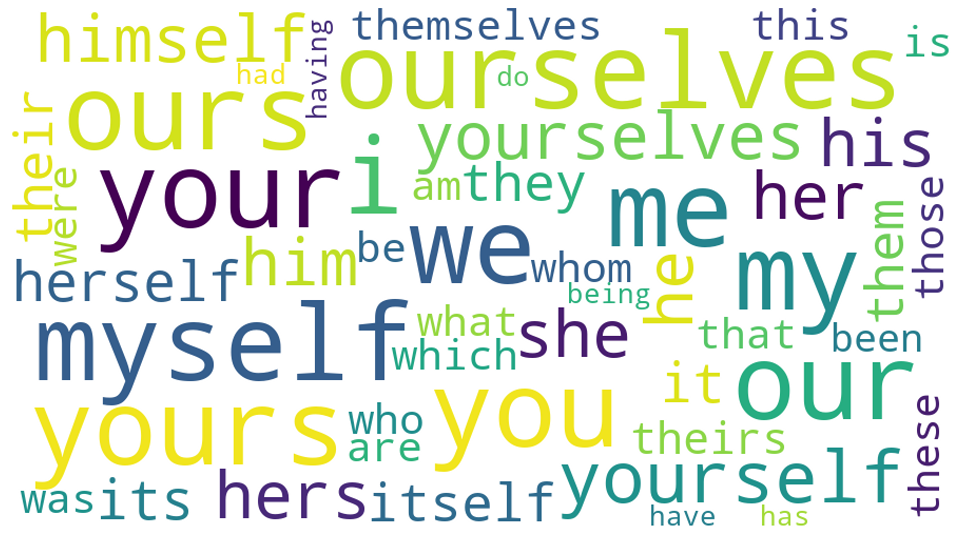

In [74]:
# create a word frequency dictionary
wordfreq = Counter(stepwords)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=50,
                      max_font_size=100,
                      relative_scaling=0.5,
                      background_color="white",
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='spline16')
plt.axis("off")
plt.show()

In [75]:
positiveWord = processed_dataset.select('token_features').where(col("label") == 0.0)

In [76]:
positiveWord.show()

+--------------------+
|      token_features|
+--------------------+
|[excel, burger, f...|
|[ic, cream, tasti...|
|[realli, great, b...|
|[great, food, ic,...|
|[first, time, ric...|
|[famili, yummi, i...|
|[iv, seen, yelp, ...|
|[worst, ic, cream...|
|[on, favorit, pla...|
|[best, burger, to...|
|[place, awesom, i...|
|[place, wonder, t...|
|[rare, post, bad,...|
|[richman, replac,...|
|[handl, cone, glo...|
|[im, alwai, pleas...|
|[like, ic, cream,...|
|[yum, good, never...|
|[burger, shake, g...|
|[scoop, soft, ser...|
+--------------------+
only showing top 20 rows



In [77]:
positiveWordList = positiveWord.select('token_features').rdd.flatMap(lambda x: x).collect()

In [78]:
#positiveWordList[:20]

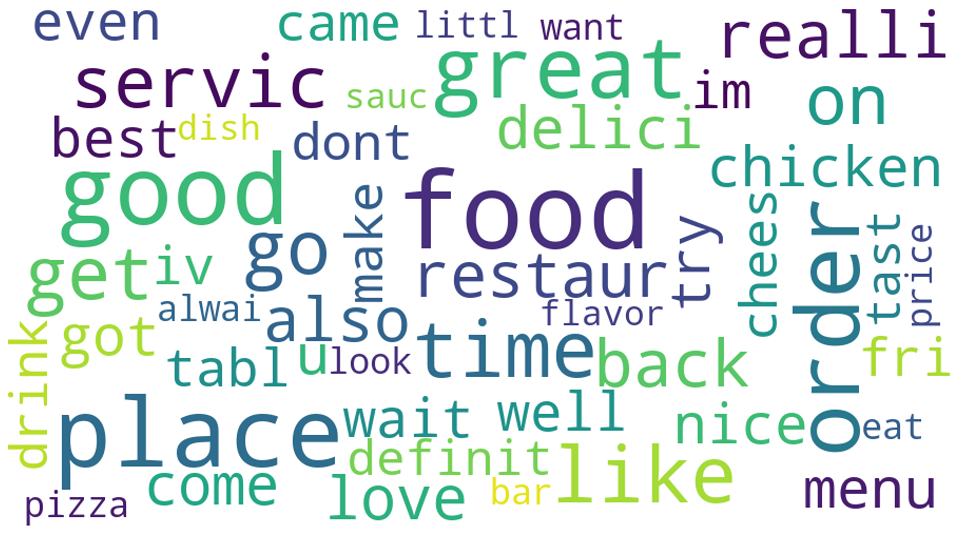

In [79]:
worldCloud(positiveWordList)

In [80]:
negativeWord = processed_dataset.select('token_features').where(col("label") == 1.0)

In [81]:
#negativeWord.show()

In [82]:
negativeWordList = negativeWord.select('token_features').rdd.flatMap(lambda x: x).collect()

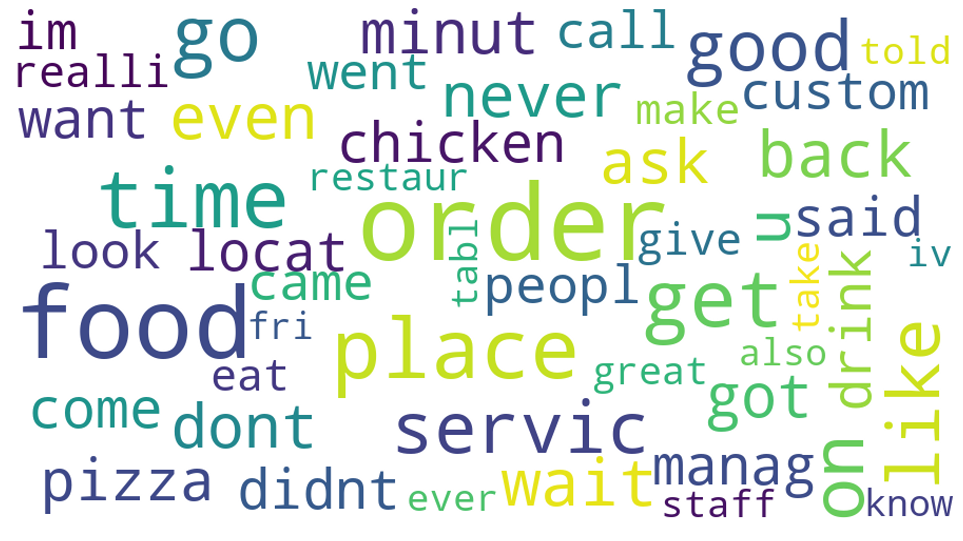

In [83]:
worldCloud(negativeWordList)

## Splitting the data :

In [84]:
training, test = processed_dataset.randomSplit([0.8,0.2] ,seed=42)

In [85]:
print("training Data" , training.count()) 
training.groupBy('label').count().show()

training Data 435848
+-----+------+
|label| count|
+-----+------+
|  0.0|422896|
|  1.0| 12952|
+-----+------+



In [86]:
print("test Data" , test.count()) 
test.groupBy('label').count().show()

test Data 108992
+-----+------+
|label| count|
+-----+------+
|  0.0|105787|
|  1.0|  3205|
+-----+------+



### Logistic Regression:

In [87]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import numpy as np

In [88]:
lg = LogisticRegression(featuresCol = 'features', labelCol='label',maxIter = 10,regParam=0.3 )
lgModel = lg.fit(training)
predictions = lgModel.transform(test)

In [89]:
predictions.groupBy('label','prediction').count().show()

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0|    64|
|  0.0|       1.0|    16|
|  1.0|       0.0|  3141|
|  0.0|       0.0|105771|
+-----+----------+------+



In [90]:
#Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
roc_auc = evaluator.evaluate(predictions)

In [91]:
#find the accuracy
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(test.count())
accuracy


0.9710345713446858

In [92]:
# print accuracy, roc_auc
print( "Accuracy Score: {0:.4f}".format(accuracy))
print ("ROC-AUC: {0:.4f}".format(roc_auc))

Accuracy Score: 0.9710
ROC-AUC: 0.9575


In [93]:
# Handling Class Imbalance Using Weights / on the minority -negative classes-
balancingRatio = processed_dataset.filter(col('label') == 1).count() / processed_dataset.count()
calculateWeights = udf(lambda x: 1 * balancingRatio if x == 0 else (1 * (1.0 - balancingRatio)), DoubleType())

weightedDataset = processed_dataset.withColumn("classWeightCol", calculateWeights('label'))
#weightedDataset.groupby('classWeightCol').count().show()

In [94]:
trainingW, testW = weightedDataset.randomSplit([0.8,0.2] ,seed=42)

In [95]:
print("training Data" , trainingW.count()) 
print("test Data" , testW.count()) 

training Data 435848
test Data 108992


In [114]:
lg = LogisticRegression(featuresCol = 'features', labelCol='label',maxIter = 10,regParam=0.3  ,weightCol="classWeightCol")
lgModel = lg.fit(trainingW)
predictions = lgModel.transform(testW)

In [97]:
predictions.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 2667|
|  0.0|       1.0|15653|
|  1.0|       0.0|  538|
|  0.0|       0.0|90134|
+-----+----------+-----+



In [115]:
#Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
roc_auclg = evaluator.evaluate(predictions)
#find the accuracy
accuracylg = predictions.filter(predictions.label == predictions.prediction).count() / float(testW.count())

In [133]:
# print accuracy, roc_auc
print("For Logistic Regression:\nAccuracy Score: {0:.4f}".format(accuracylg))
print ("ROC-AUC: {0:.4f}".format(roc_auclg))

For Logistic Regression:
Accuracy Score: 0.8514
ROC-AUC: 0.8979


### Random Forest:

In [100]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees = 100, maxDepth = 4)
# Train model with Training Data
rfModel = rf.fit(trainingW)
predictions = rfModel.transform(testW)

In [101]:
#Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
roc_auc_rf = evaluator.evaluate(predictions)
#find the accuracy
accuracy_rf = predictions.filter(predictions.label == predictions.prediction).count() / float(testW.count())

In [112]:
# print accuracy, roc_auc
print( "For Random Forest:\nAccuracy Score: {0:.4f}".format(roc_auc_rf))
print ("ROC-AUC: {0:.4f}".format(accuracy_rf))

For Random Forest:
Accuracy Score: 0.9561
ROC-AUC: 0.9706


### SVM:

In [106]:
from pyspark.ml.classification import LinearSVC
lsvm = LinearSVC(labelCol="label", maxIter=50 ,weightCol="classWeightCol")
svm = lsvm.fit(trainingW)
predictions_svm = svm.transform(testW)

In [107]:
#Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
roc_auc_svm = evaluator.evaluate(predictions)
#find the accuracy
accuracy_svm = predictions.filter(predictions.label == predictions.prediction).count() / float(testW.count())

In [113]:
# print accuracy, roc_auc
print("For Support Vector Machines(SVM):\nAccuracy Score: {0:.4f}".format(accuracy_svm))
print("ROC-AUC: {0:.4f}".format(roc_auc_svm))

For Support Vector Machines(SVM):
Accuracy Score: 0.9706
ROC-AUC: 0.9561
